In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\z004hn4c\Anaconda3\envs\pythonProject\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\z004hn4c\Anaconda3\envs\pythonProject\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\z004hn4c\Anaconda3\envs\pythonProject\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
def get_image(path, img_transform, size=(600,600)):
    image=Image.open(path)
    image=image.resize(size,Image.LANCZOS)
    image=img_transform(image).unsqueeze(0)
    return image.to(device)

def get_gram(m):
    '''
    m is of shape(1,C,H,W)
    '''
    _,C,h,w=m.size()
    m=m.view(c,h*w)
    m=torch.mm(m,m.t())
    return m

def denormalize_img(inp):
    inp=inp.numpy().transpose((1,2,0))
    mean=np.array([0.485, 0.456, 0.406])
    std=np.array([0.299, 0.224, 0.225])
    inp=inp*std+mean #(inp-mean)/std
    inp=inp.clip(inp,0,1)
    return inp

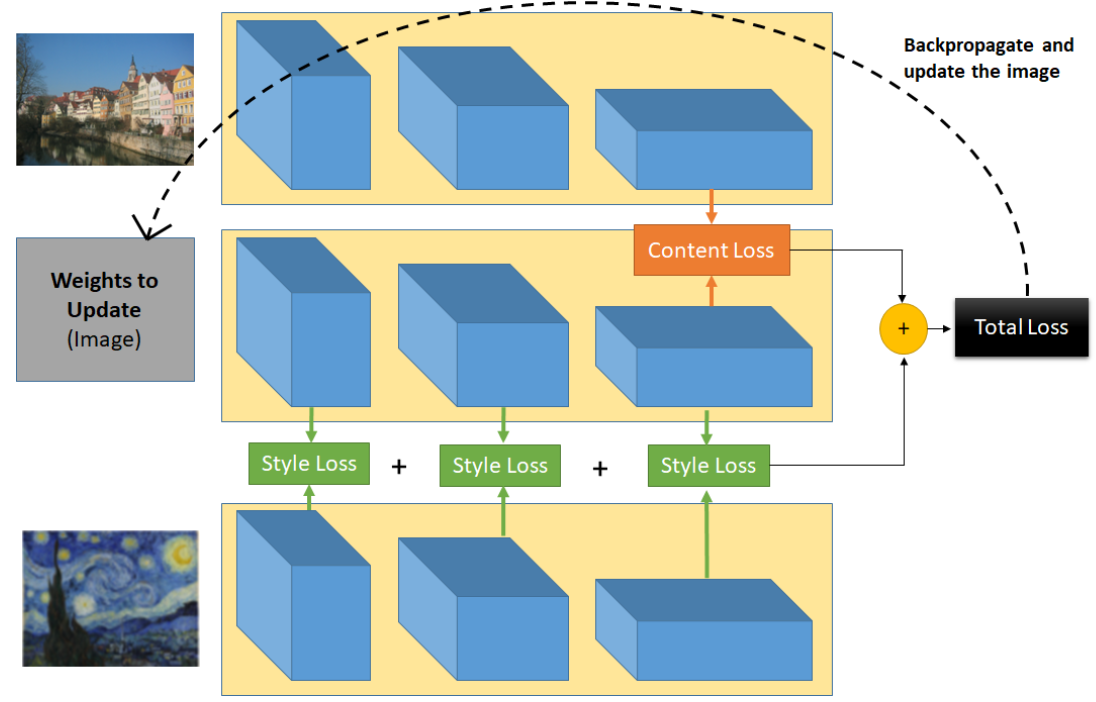

In [3]:
class FeatureExtractor(nn.Module):
    def __init__(self) -> None:
        super(FeatureExtractor, self).__init__()
        self.selected_layers=[3,8,15,22]
        self.vgg=models.vgg16(pretrained=True).features

    def forward(self,x):
        layer_feats=[]
        for layer_num, layer in self.vgg._modules.items():
            x=layer(x)
            if int(layer_num) in self.selected_layers:
                layer_feats.append(x)
        return layer_feats            

In [4]:
models.vgg16(pretrained=True).features._modules.items()

C:\Users\z004hn4c\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\z004hn4c\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


odict_items([('0', Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('1', ReLU(inplace=True)), ('2', Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('3', ReLU(inplace=True)), ('4', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('5', Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('6', ReLU(inplace=True)), ('7', Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('8', ReLU(inplace=True)), ('9', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('10', Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('11', ReLU(inplace=True)), ('12', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('13', ReLU(inplace=True)), ('14', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('15', ReLU(inplace=True)), ('16', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('17', Conv2d(25

In [5]:
img_transform = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

content_img=get_image("guitarra-les-paul-gibson-1.jpg", img_transform)
style_img=get_image("Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg", img_transform)
generated_img=content_img.clone()
generated_img.requires_grad=True

optmizer=torch.optim.Adam([generated_img], lr=0.005, betas=[0.5,0.999])
enconder=FeatureExtractor().to(device)

for p in enconder.parameters():
    p.requires_grad=False

In [6]:
content_weight=1
style_weight=300

for epoch in range(3800):

    content_features=enconder(content_img)
    style_features=enconder(style_img)
    generated_features=enconder(generated_img)

    content_loss=torch.mean((content_features[-1]-generated_features[-1])**2)

    style_loss=0
    for gf,sf in zip(generated_features, style_features):
        _,c,h,w=gf.size()
        gram_gf=get_gram(gf)
        gram_sf=get_gram(sf)
        style_loss+=torch.mean((gram_gf-gram_sf)**2 / (c*h*w))

    loss=content_weight*content_loss+style_weight*style_loss
    optmizer.zero_grad()
    loss.backward()
    optmizer.step()

    if epoch %10==0:
        print('Epoch [{}]\tContent Loss: {:.4f}\tStyle Loss: {:.4f}'.format(epoch, content_loss.item(), style_loss.item()))    


Epoch [0]	Content Loss: 0.0000	Style Loss: 7091.5166
Epoch [10]	Content Loss: 0.8915	Style Loss: 5516.4912
Epoch [20]	Content Loss: 1.5051	Style Loss: 4436.0288
Epoch [30]	Content Loss: 1.8409	Style Loss: 3722.2715
Epoch [40]	Content Loss: 2.0291	Style Loss: 3193.5410
Epoch [50]	Content Loss: 2.1629	Style Loss: 2774.0391
Epoch [60]	Content Loss: 2.2656	Style Loss: 2432.6953
Epoch [70]	Content Loss: 2.3474	Style Loss: 2150.8735
Epoch [80]	Content Loss: 2.4137	Style Loss: 1914.8295
Epoch [90]	Content Loss: 2.4690	Style Loss: 1714.2828
Epoch [100]	Content Loss: 2.5175	Style Loss: 1541.5137
Epoch [110]	Content Loss: 2.5629	Style Loss: 1390.9465
Epoch [120]	Content Loss: 2.6036	Style Loss: 1258.3234
Epoch [130]	Content Loss: 2.6416	Style Loss: 1140.6399
Epoch [140]	Content Loss: 2.6783	Style Loss: 1035.5883
Epoch [150]	Content Loss: 2.7119	Style Loss: 941.3504
Epoch [160]	Content Loss: 2.7437	Style Loss: 856.4850
Epoch [170]	Content Loss: 2.7741	Style Loss: 779.9105
Epoch [180]	Content Loss

In [7]:
def denormalize_img(inp):
    inp=inp.numpy().transpose((1,2,0))
    mean=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])  # Corrigi o valor do std para estar de acordo com a normalização
    inp=inp * std + mean  #(inp-mean)/std
    inp=np.clip(inp, 0, 1)
    return inp


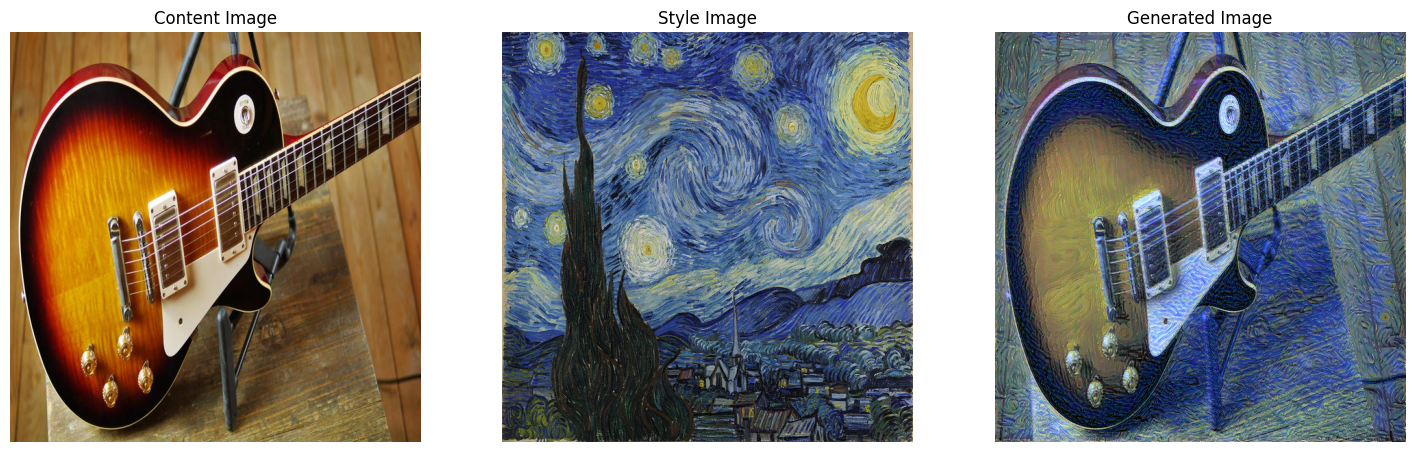

In [8]:
# Function to denormalize and prepare image for plotting
def prepare_img_for_plot(img):
    img = img.detach().cpu().squeeze()
    img = denormalize_img(img)
    return img

# Prepare the images
content_img_plot = prepare_img_for_plot(content_img)
style_img_plot = prepare_img_for_plot(style_img)
generated_img_plot = prepare_img_for_plot(generated_img)

# Plotting the images side by side
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(content_img_plot)
plt.title("Content Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(style_img_plot)
plt.title("Style Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(generated_img_plot)
plt.title("Generated Image")
plt.axis('off')

plt.show()